In [3]:
import h5py
import json
from PIL import Image
import io
import numpy as np
import os
import tqdm
import copy
import pickle
import matplotlib.pyplot as plt
import copy
from vis import imshow_tracks
from generate_html import HTML
%load_ext autoreload
%autoreload 2

# Visualize the genreated fake image pairs

In [5]:
## read the generated images
img_client = h5py.File('../../data/tao/ovtrack/ovtrack_lvis_generated_image_pairs_repeat_1.h5', "r")

In [6]:
## read the generated annotations
generated_annotations = json.load(open('../../data/tao/annotations/ovtrack/ovtrack_lvis_generated_image_pairs_repeat_1.json'))

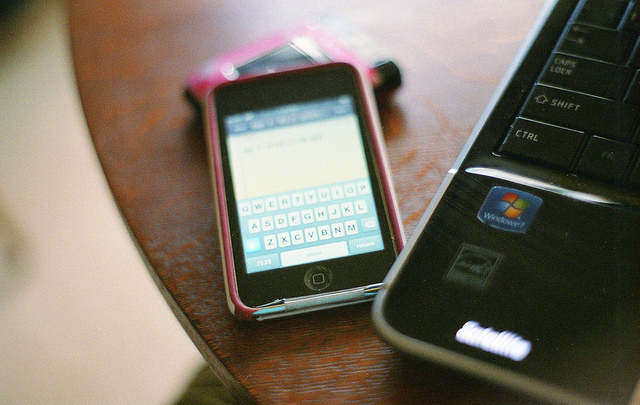

In [38]:
# we take a relative bigger index due to we also include original images in the beginning of the list.
index = 100001
imname = generated_annotations['images'][index]['file_name']
value_buf = img_client[imname]
image_data = np.array(value_buf)
image = Image.open(io.BytesIO(image_data))
image

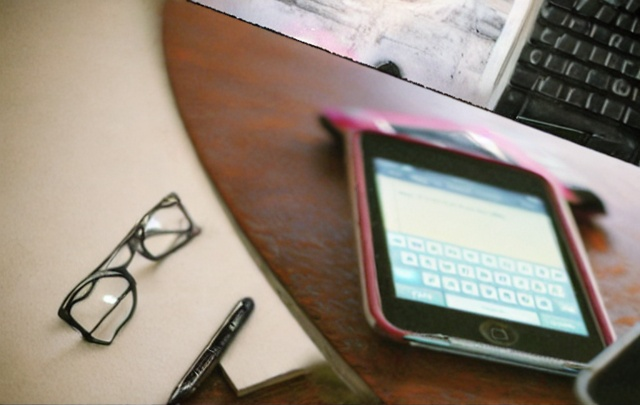

In [26]:
imname = generated_annotations['images'][index+1]['file_name']
value_buf = img_client[imname]
image_data = np.array(value_buf)
image = Image.open(io.BytesIO(image_data))
image

In [29]:
# build the category id to category information mapping
cid_cinfo_mapping = {}
for item in generated_annotations['categories']:
    cid = item['id']
    if cid not in cid_cinfo_mapping:
        cid_cinfo_mapping[cid] = item
        
# build the image id to its annotations mapping
imid_anno_mapping = {}
for item in generated_annotations['annotations']:
    imid = item['image_id']
    if imid not in imid_anno_mapping:
        imid_anno_mapping[imid] = [item]
    else:
        imid_anno_mapping[imid].append(item)
        
        
def draw_fake_annotations(image, annos):
    
    # retrive annotations
    bboxes =[[item['bbox'][0], 
              item['bbox'][1], 
              item['bbox'][0]+item['bbox'][2], 
              item['bbox'][1] + item['bbox'][3]] 
             for item in annos]
    labels = [cid_cinfo_mapping[item['category_id']]['name'] for item in annos]
    ids = [item['track_id'] for item in annos]
    bboxes = np.array(bboxes)
    labels = np.array(labels)
    ids = np.array(ids)
    # draw bounding box
    r_img = imshow_tracks(np.array(image.convert('RGB')), bboxes, labels, ids , backend='cv2')
    
    return r_img

### draw images with the annotations

In [30]:
# select a path where you want to save your images
save_dir = './ovtrack_generation_test/'
save_images_dir = f'{save_dir}/images'
os.makedirs(save_images_dir, exist_ok=True)

# we select 1000 images from the whole generate dataset starting from 100000
for i in range(100000, 110000):
    # retrieve image
    imname = generated_annotations['images'][i]['file_name']
    imid = generated_annotations['images'][i]['id']
    value_buf = img_client[imname]
    image_data = np.array(value_buf)
    image = Image.open(io.BytesIO(image_data))
    if imid not in imid_anno_mapping:
        image.save(os.path.join(save_images_dir, imname))
        continue
    annos = imid_anno_mapping[imid]
    
    # draw fake annotations
    image_arr =  draw_fake_annotations(image, annos)
    image = Image.fromarray(image_arr)
    image.save(os.path.join(save_images_dir, imname))

### generated html file 

In [31]:
# generate a html file 
webpage = HTML(save_dir, 'Experiment name = pesudo pairs')
images_list  =  os.listdir(save_dir + 'images')
imid_name_mapping = {}
for imname in images_list:
    # skip some hide files generated by jupyter
    if imname.startswith('.'):
        continue
    # we use _v0, _v1 and so on to index the generated images, so if _ not in the image it means it is an original image
    if '_' not in imname:
        imid = int(imname[:-4])
        if imid not in imid_name_mapping:
            imid_name_mapping[imid] = [imname]
        else:
            imid_name_mapping[imid].append(imname)
            
    else:
        imid = int(imname.split('_')[0])
        if imid not in imid_name_mapping:
            imid_name_mapping[imid] = [imname]
        else:
            imid_name_mapping[imid].append(imname)
        
# adding the image name to the html
for imid in imid_name_mapping:
    
    webpage.add_header(imid)
    ims, txts, links = [], [], []
    tmp_list = sorted(imid_name_mapping[imid])

    for item in tmp_list:
        img_path = item
        label = item
        ims.append(img_path)
        txts.append(label)
        links.append(img_path)
    webpage.add_images(ims, txts, links)
webpage.save()

Now you can open the html file in the `save_dir`